Maritime choke Points
https://www.visualcapitalist.com/mapping-the-worlds-key-maritime-choke-points/

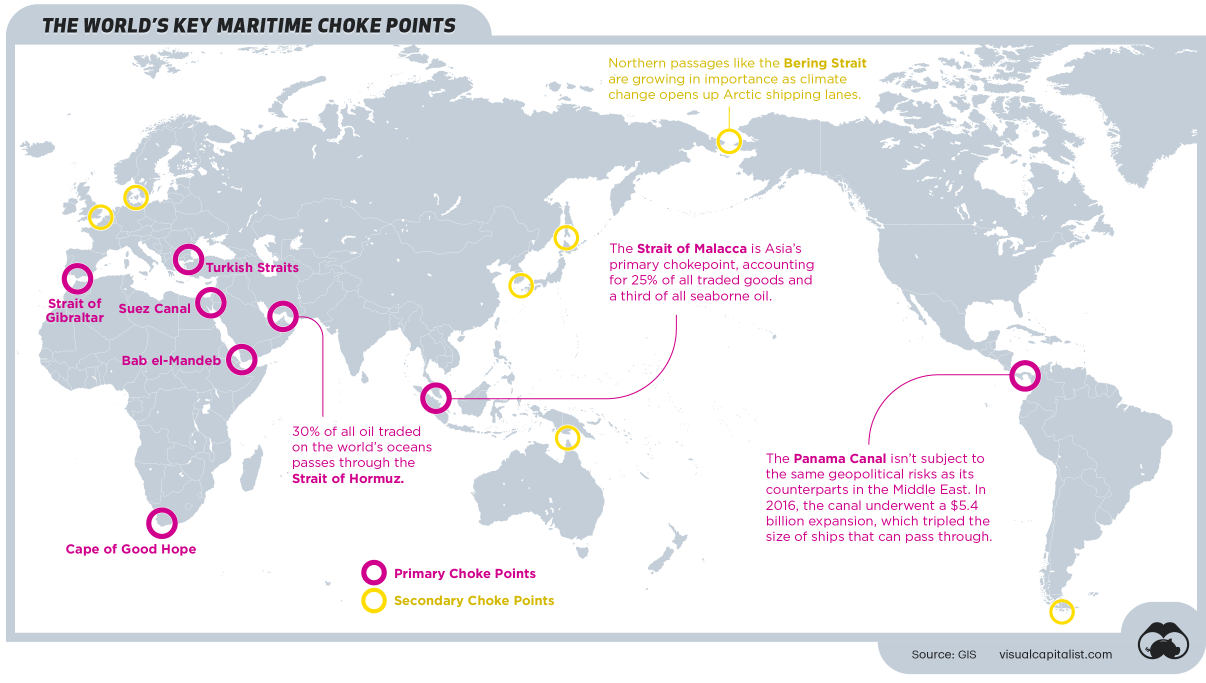

In [1]:
from ais import functions as af
from pyspark.sql import functions as F
from pyspark.sql.types import StringType

In [2]:
from shapely.geometry import Polygon

In [3]:
import geopandas as gpd
import pandas as pd
import numpy as np

import folium

In [4]:
pd.set_option('display.max_columns', None) #Show all columns in pandas df
pd.set_option('display.max_rows', 100) #Show 100 rows in pandas df
pd.options.display.float_format = '{:.10f}'.format #Show float with 10 decimal points in pandas df

from IPython.core.interactiveshell import InteractiveShell #allow multiple outputs in one jupyter cell
InteractiveShell.ast_node_interactivity = "all"

In [5]:
bucket = "ungp-ais-data-historical-backup"
path = f"s3a://{bucket}/user_temp/adb/"

In [20]:
#boto3 <- s3 api for python

In [6]:
import h3.api.numpy_int as h3int

In [7]:
from IPython.display import HTML
import base64

def download_map(m, filename="map.html", title="map.html"):
    #m is folium map    
    html_string = m.get_root().render()
    b64 = base64.b64encode(html_string.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'   
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

# Map Port Buffers

In [23]:
ports_df = pd.read_pickle(path+"ki/wpi_22KM_v2.pkl")
ports_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 3757 entries, 0 to 3648
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Country              3757 non-null   object  
 1   Port                 3757 non-null   object  
 2   port_id              3757 non-null   float64 
 3   location             3757 non-null   geometry
 4   EPSG                 3757 non-null   object  
 5   buffer_22KM          3757 non-null   geometry
 6   buffer_area          3757 non-null   float64 
 7   buffer_grouped_id    3757 non-null   int64   
 8   buffer_22KM_grouped  3757 non-null   geometry
 9   buffer_h3_poly       3757 non-null   geometry
 10  grouped_country      3757 non-null   object  
 11  grouped_port         3757 non-null   object  
dtypes: float64(2), geometry(4), int64(1), object(5)
memory usage: 381.6+ KB


In [24]:
wpi = pd.read_pickle(path+"ki/WPI.pkl")
wpi.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3757 entries, 0 to 3756
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   World Port Index Number  3757 non-null   float64 
 1   Port                     3757 non-null   object  
 2   UN/LOCODE                3757 non-null   object  
 3   Country                  3757 non-null   object  
 4   Harbor Size              3757 non-null   object  
 5   Harbor Type              3757 non-null   object  
 6   Latitude                 3757 non-null   float64 
 7   Longitude                3757 non-null   float64 
 8   geometry                 3757 non-null   geometry
 9   h3                       3757 non-null   int64   
dtypes: float64(3), geometry(1), int64(1), object(5)
memory usage: 293.6+ KB


In [26]:
ports_selected = ['Indonesia']
buffer_grouped_ids = ports_df[ports_df['Country'].isin(ports_selected)].buffer_grouped_id.unique()
ports_df_chosen =  ports_df[ports_df['Country'].isin(ports_selected)]

wpi_chosen = wpi[wpi["Country"].isin(ports_df_chosen['Country']) & wpi["Country"].isin(ports_df_chosen["Country"])]
             
m = folium.Map(location=[wpi_chosen['Latitude'].iloc[0], wpi_chosen['Longitude'].iloc[0]], 
               tiles="cartodbpositron nolabels",
               zoom_start=2
              )
# m = folium.Map()

tile = folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = False,
        control = True
       ).add_to(m)

tile = folium.TileLayer(
        tiles = "cartodbpositron",
        overlay = False,
        control = True
       ).add_to(m)

a = folium.GeoJson(ports_df_chosen[['Country','buffer_grouped_id','buffer_22KM']].set_geometry("buffer_22KM").set_crs('epsg:4326'),
                   name="Port Buffer",
                   style_function=lambda x: {'fillColor':'blue', 'weight':0},
                   tooltip=folium.GeoJsonTooltip(fields=['buffer_grouped_id']),
                  ).add_to(m)

a = folium.GeoJson(wpi_chosen[wpi_chosen['Country'].isin(['Indonesia'])][['Country','Port','World Port Index Number','geometry']].to_json(),
                   tooltip=folium.GeoJsonTooltip(fields=['Country','Port','World Port Index Number']),
                   name="Port",
                   marker = folium.Marker(icon=folium.Icon(color='blue')),
                   show=False
                  ).add_to(m)


buffer_grouped_ids = ports_df[ports_df['Port'].isin(ports_selected)].buffer_grouped_id.unique()

ports_df_others = ports_df[~ports_df['Port'].isin(ports_selected) & ports_df['buffer_grouped_id'].isin(buffer_grouped_ids)]
wpi_chosen = wpi[wpi['World Port Index Number'].isin(ports_df_others['port_id'])]
a = folium.GeoJson(wpi_chosen[['Country','Port','World Port Index Number','geometry']].to_json(),
                   tooltip=folium.GeoJsonTooltip(fields=['Country','Port','World Port Index Number']),
                   name="Port",
                   marker = folium.Marker(icon=folium.Icon(color='orange')),
                   show=False
                  ).add_to(m)

folium.LayerControl().add_to(m)

m

IndexError: list index out of range

In [36]:
ports_df_others['port_id']


843    50060.0000000000
852    50040.0000000000
1447   49982.0000000000
2185   50045.0000000000
2871   50030.0000000000
2917   51587.0000000000
2961   50516.0000000000
2992   50055.0000000000
335    59974.0000000000
648    59991.0000000000
663    59985.0000000000
697    59990.0000000000
2890   59976.0000000000
664    59986.0000000000
665    59987.0000000000
682    59988.0000000000
700    59995.0000000000
1033   31050.0000000000
1490   31060.0000000000
1491   31040.0000000000
1639   31100.0000000000
2842   31070.0000000000
Name: port_id, dtype: float64

,World Port Index Number,Port,UN/LOCODE,Country,Harbor Size,Harbor Type,Latitude,Longitude,geometry,h3
335,59974.0000000000,Changshu,CN CGS,China,Small,Open Roadstead,31.7666670000,120.9500000000,POINT (120.95000 31.76667),613344783942811647
648,59991.0000000000,Nantong,CN NTG,China,Small,River (Natural),32.0000000000,120.8000000000,POINT (120.80000 32.00000),613344784922181631
663,59985.0000000000,Jiangyin,CN JGY,China,Small,River (Natural),31.9166670000,120.2333330000,POINT (120.23333 31.91667),613344726204022783
664,59986.0000000000,Changzhou,CN CZX,China,Small,Open Roadstead,31.9666670000,119.9833330000,POINT (119.98333 31.96667),613344696934072319
665,59987.0000000000,Gaogang,CN GAO,China,Small,River (Natural),32.2833330000,119.8500000000,POINT (119.85000 32.28333),613344731448999935
682,59988.0000000000,Yangzhou,CN YZH,China,Small,River (Natural),32.2666670000,119.4333330000,POINT (119.43333 32.26667),613343983057240063
697,59990.0000000000,Zhangjiangang,CN ZJG,China,Small,River (Natural),31.9666670000,120.4000000000,POINT (120.40000 31.96667),613344703458312191
700,59995.0000000000,Zhenjiang,CN ZHE,China,Small,River (Natural),32.2166670000,119.4333330000,POINT (119.43333 32.21667),613344753343266815
843,50060.0000000000,Pulau Sambu,ID PSS,Indonesia,Small,Coastal (Natural),1.1666670000,103.9000000000,POINT (103.90000 1.16667),614269015501570047
852,50040.0000000000,Tanjungpinang,ID TNJ,Indonesia,Very Small,Open Roadstead,0.9166670000,104.4500000000,POINT (104.45000 0.91667),614268857969803263


In [19]:
download_map(m, filename="Rotterdam Shanghai Singaport Ningbo Zhoushan.html", title="map.html")

# Data 

## Ports

In [10]:
ports_df = pd.read_pickle(path+"ki/wpi_22KM_v2.pkl")
ports_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 3757 entries, 0 to 3648
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Country              3757 non-null   object  
 1   Port                 3757 non-null   object  
 2   port_id              3757 non-null   float64 
 3   location             3757 non-null   geometry
 4   EPSG                 3757 non-null   object  
 5   buffer_22KM          3757 non-null   geometry
 6   buffer_area          3757 non-null   float64 
 7   buffer_grouped_id    3757 non-null   int64   
 8   buffer_22KM_grouped  3757 non-null   geometry
 9   buffer_h3_poly       3757 non-null   geometry
 10  grouped_country      3757 non-null   object  
 11  grouped_port         3757 non-null   object  
dtypes: float64(2), geometry(4), int64(1), object(5)
memory usage: 381.6+ KB


In [11]:
wpi = pd.read_pickle(path+"ki/WPI.pkl")
wpi.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3757 entries, 0 to 3756
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   World Port Index Number  3757 non-null   float64 
 1   Port                     3757 non-null   object  
 2   UN/LOCODE                3757 non-null   object  
 3   Country                  3757 non-null   object  
 4   Harbor Size              3757 non-null   object  
 5   Harbor Type              3757 non-null   object  
 6   Latitude                 3757 non-null   float64 
 7   Longitude                3757 non-null   float64 
 8   geometry                 3757 non-null   geometry
 9   h3                       3757 non-null   int64   
dtypes: float64(3), geometry(1), int64(1), object(5)
memory usage: 293.6+ KB


In [12]:
poly_sdf = spark.read.parquet(f"{path}ki/global_polygon/")
poly_sdf.printSchema()

root
 |-- buffer_grouped_id: long (nullable = true)
 |-- H3_int_index_8: decimal(20,0) (nullable = true)
 |-- port_id: double (nullable = true)
 |-- port_id_list: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- port_count: long (nullable = true)
 |-- passage_part_id: long (nullable = true)
 |-- passage_id: long (nullable = true)



In [13]:
overlap_df = poly_sdf.filter(~F.col("passage_id").isNull() & ~F.col("port_id").isNull()).select("buffer_grouped_id").distinct().toPandas()

In [16]:
overlap_df.head()

,buffer_grouped_id
0,730
1,724
2,1471
3,1330
4,642


In [14]:
# ports_df = pd.read_pickle(path+"ki/wpi_22KM.pkl")
passthru_df = pd.concat([pd.read_pickle(f"{path}ki/Passthru_Buffer.pkl"),
                         pd.read_pickle(f"{path}ki/Passthru.pkl").rename(columns={'Passage_Part':'Passage Part'})
                        ])
passthru_df = gpd.GeoDataFrame(passthru_df, crs="epsg:4326")
passthru_df['buffer_poly'] = passthru_df['buffer_grouped_id'].map(ports_df[['buffer_grouped_id','buffer_22KM_grouped']].drop_duplicates().set_index("buffer_grouped_id")['buffer_22KM_grouped'])
passthru_df['geometry'] = passthru_df['geometry'].fillna(passthru_df['buffer_poly'])

passthru_df = passthru_df.drop(columns=['buffer_poly'])
passthru_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 29 entries, 0 to 16
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   buffer_grouped_id  12 non-null     float64 
 1   Passage Part       29 non-null     object  
 2   Passage            29 non-null     object  
 3   passage_part_id    29 non-null     int64   
 4   passage_id         29 non-null     int64   
 5   geometry           29 non-null     geometry
dtypes: float64(1), geometry(1), int64(2), object(2)
memory usage: 1.6+ KB


/opt/conda/lib/python3.8/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(


# Map Passageway

In [17]:
passthru_df.reset_index(drop=True, inplace=True)

In [18]:
SG_center = passthru_df[passthru_df['Passage']=="Singapore Strait"].iloc[1:2,].centroid.iloc[0]

/tmp/ipykernel_51/2683533488.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  SG_center = passthru_df[passthru_df['Passage']=="Singapore Strait"].iloc[1:2,].centroid.iloc[0]


In [19]:
passthru_center = passthru_df.dissolve(["Passage","passage_id"]).centroid.reset_index().rename(columns={0:'geometry'})
passthru_center = passthru_center.set_geometry('geometry')
passthru_center.loc[passthru_center["Passage"]=="Singapore Strait","geometry"] = SG_center
passthru_center

/tmp/ipykernel_51/2390942612.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  passthru_center = passthru_df.dissolve(["Passage","passage_id"]).centroid.reset_index().rename(columns={0:'geometry'})


,Passage,passage_id,geometry
0,Bab El-Mandeb Strait,1,POINT (42.97672 13.37522)
1,Bering Strait,3,POINT (-168.93217 65.56294)
2,Bosphorus Strait,11,POINT (29.21690 40.76239)
3,Cape of Good Hope,13,POINT (18.42668 -34.05103)
4,Danish Straits,18,POINT (12.49296 55.94573)
5,Dardanelles Strait,12,POINT (26.51417 40.27409)
6,English Channel,10,POINT (2.26848 51.17992)
7,Gibraltar Strait,8,POINT (-5.52797 35.94120)
8,Korea Strait,6,POINT (129.60555 34.71341)
9,La Pérouse Strait,5,POINT (142.18314 45.64827)


In [20]:
primary = [1,11,13,12,18,8,14,2,17,7]

In [21]:
# ports_df[ports_df['Country']=="Denmark"]

In [22]:
# buffer_passage = passthru_df['buffer_grouped_id'].unique().tolist()
ports_df_chosen = ports_df[ports_df['buffer_grouped_id'].isin(overlap_df['buffer_grouped_id'])]
wpi_chosen = wpi[wpi["Port"].isin(ports_df_chosen['Port'])& wpi["Country"].isin(ports_df_chosen["Country"])]
             
m = folium.Map(location=[wpi_chosen['Latitude'].iloc[0], wpi_chosen['Longitude'].iloc[0]], 
               tiles="cartodbpositron nolabels",
               zoom_start=2
              )
# m = folium.Map()

tile = folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = False,
        control = True
       ).add_to(m)

a = folium.GeoJson(ports_df_chosen[['Country','buffer_grouped_id','buffer_22KM_grouped']].drop_duplicates(subset='buffer_grouped_id').set_geometry("buffer_22KM_grouped").drop_duplicates(),
                   name="Port Buffer",
                   style_function=lambda x: {'fillColor':'red', 'weight':0},
                   tooltip=folium.GeoJsonTooltip(fields=['buffer_grouped_id']),
                  ).add_to(m)

a = folium.GeoJson(passthru_df,
                   name="Passages",
                   tooltip=folium.GeoJsonTooltip(fields=['Passage Part','Passage']),
                   show=False
                  ).add_to(m)

feature_group = folium.FeatureGroup('Passage Point')
a = folium.GeoJson(passthru_center[passthru_center['passage_id'].isin(primary)] ,
                   # name="Passage Point",
                   marker = folium.CircleMarker(color="#f72b0d"),
                   tooltip=folium.GeoJsonTooltip(fields=['Passage']),
                   # show=True
                  ).add_to(feature_group)

a = folium.GeoJson(passthru_center[~passthru_center['passage_id'].isin(primary)] ,
                   # name="Passage Point",
                   marker = folium.CircleMarker(color="#00a3cc"),
                   tooltip=folium.GeoJsonTooltip(fields=['Passage']),
                   # show=True
                  ).add_to(feature_group)

feature_group.add_to(m)


a = folium.GeoJson(wpi_chosen[['Country','Port','World Port Index Number','geometry']].to_json(),
                   tooltip=folium.GeoJsonTooltip(fields=['Country','Port','World Port Index Number']),
                   name="Port",
                   marker = folium.Marker(icon=folium.Icon(color='blue')),
                   show=False
                  ).add_to(m)

folium.LayerControl().add_to(m)

m

In [23]:
# download_map(m, filename="Overlapping Ports in Multiple Countries.html", title="Overlapping Ports in Multiple Countries.html")
download_map(m, filename="Passageways 20230627 v2.html", title="Passageways 20230627 v2.html")

# Map Passageway H3

In [49]:
import h3.api.numpy_int as h3int

In [50]:
from shapely.geometry import Polygon, Point

In [54]:
ports_df[ports_df['Country']=="Singapore"]

,Country,Port,port_id,location,EPSG,buffer_22KM,buffer_area,buffer_grouped_id,buffer_22KM_grouped,buffer_h3_poly,grouped_country,grouped_port
3753,Singapore,Singapore,50000.0000000000,POINT (103.68283 1.26445),epsg:32648,"POLYGON ((103.88045 1.46354, 103.88062 1.06554...",1936000000.0000000000,1074,"POLYGON ((103.63097 1.04760, 103.63108 0.78444...","POLYGON ((103.69929 1.01411, 103.70345 1.01123...","{Singapore, Indonesia, Malaysia}","[Pulau Sambu, Tanjungpinang, Johor, Kijang, Ta..."
3754,Singapore,Singapore,50000.0000000000,POINT (104.02690 1.33619),epsg:32648,"POLYGON ((104.22457 1.53528, 104.22469 1.13724...",1936000000.0000000000,1074,"POLYGON ((103.63097 1.04760, 103.63108 0.78444...","POLYGON ((103.69929 1.01411, 103.70345 1.01123...","{Singapore, Indonesia, Malaysia}","[Pulau Sambu, Tanjungpinang, Johor, Kijang, Ta..."
3755,Singapore,Singapore,50000.0000000000,POINT (103.91627 1.29118),epsg:32648,"POLYGON ((104.11392 1.49027, 104.11406 1.09224...",1936000000.0000000000,1074,"POLYGON ((103.63097 1.04760, 103.63108 0.78444...","POLYGON ((103.69929 1.01411, 103.70345 1.01123...","{Singapore, Indonesia, Malaysia}","[Pulau Sambu, Tanjungpinang, Johor, Kijang, Ta..."
3756,Singapore,Singapore,50000.0000000000,POINT (103.77068 1.24665),epsg:32648,"POLYGON ((103.96831 1.44575, 103.96847 1.04773...",1936000000.0000000000,1074,"POLYGON ((103.63097 1.04760, 103.63108 0.78444...","POLYGON ((103.69929 1.01411, 103.70345 1.01123...","{Singapore, Indonesia, Malaysia}","[Pulau Sambu, Tanjungpinang, Johor, Kijang, Ta..."


In [52]:
passthru_df[~passthru_df.passage_id.duplicated(keep=False)]

,buffer_grouped_id,Passage Part,Passage,passage_part_id,passage_id,geometry
3,579.0000000000,Gibraltar Strait,Gibraltar Strait,1,8,"POLYGON ((-5.07825 36.10267, -5.06790 35.70623..."
4,642.0000000000,English Channel,English Channel,1,10,"POLYGON ((0.88356 51.13302, 0.88206 51.16586, ..."
5,885.0000000000,Bosphorus Strait,Bosphorus Strait,1,11,"POLYGON ((28.95548 40.76445, 28.43435 40.77210..."
6,798.0000000000,Dardanelles Strait,Dardanelles Strait,1,12,"POLYGON ((26.40757 40.38147, 26.40568 40.59715..."
7,730.0000000000,Cape of Good Hope,Cape of Good Hope,1,13,"POLYGON ((18.17238 -34.10962, 18.18545 -33.713..."


In [62]:
passage_id = 17
buffer_grouped_id=1074

In [63]:
port_df = ports_df[ports_df['buffer_grouped_id'] == buffer_grouped_id][['Country','Port','location','port_id']].set_geometry('location')

In [64]:
poly_df = poly_sdf.filter(F.col('passage_id') == passage_id).select("H3_int_index_8","port_id","port_id_list").toPandas()
poly_df['geometry'] = poly_df['H3_int_index_8'].apply(lambda x: Polygon(h3int.h3_to_geo_boundary(x, geo_json=True)))

In [65]:
poly_df = gpd.GeoDataFrame(poly_df,
                 geometry='geometry',
                 crs='epsg:4326'
                )

poly_df['port'] = poly_df['port_id_list'].astype('str')
poly_df['count'] = poly_df['port'].map(poly_df['port'].value_counts())

In [66]:
count_df = poly_df['port'].value_counts().reset_index().rename(columns={'index':'port','port':'count'})

In [67]:
lat = h3int.h3_to_geo(poly_df.iloc[0].H3_int_index_8)[0]
long = h3int.h3_to_geo(poly_df.iloc[0].H3_int_index_8)[1]

m = folium.Map(location=[lat,long], zoom_start=7)
# m = folium.Map()

tile = folium.TileLayer(
        # tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        # attr = 'Esri',
        # name = 'Esri Satellite',
        overlay = False,
        control = True,
        tiles="cartodbpositron"
       ).add_to(m)

# a = folium.Choropleth(geo_data=poly_df[['port','geometry']].to_json(),
#                       name='H3',
#                       data = poly_df['count'].reset_index(), 
#                       columns = ['index','count'],
#                       key_on='feature.id',
#                    # tooltip=folium.GeoJsonTooltip(fields=['port']),
#                       fill_opacity=0.8,
#                       line_opacity=0.2,
#                   ).add_to(m)

a = folium.GeoJson(poly_df[['port','geometry']].dissolve("port").reset_index(),
                   name="Label",
                   tooltip=folium.GeoJsonTooltip(fields=['port']),
                   style_function = lambda x: {'fillOpacity':0}
                  ).add_to(m)


a = folium.GeoJson(port_df.to_json(),
                   tooltip=folium.GeoJsonTooltip(fields=['Country','Port','port_id']),
                   name="Port"
                  ).add_to(m)


folium.LayerControl().add_to(m)

m

In [24]:
ports_df

,Country,Port,port_id,location,EPSG,buffer_22KM,buffer_area,buffer_grouped_id,buffer_22KM_grouped,buffer_h3_poly,grouped_country,grouped_port
0,United States,Maurer,7950.0000000000,POINT (-74.25000 40.53333),epsg:32618,"POLYGON ((-73.98728 40.72952, -73.99323 40.333...",1936000000.0000000000,296,"POLYGON ((-75.39172 40.09763, -75.39201 40.147...","POLYGON ((-73.80728 40.24429, -73.81163 40.247...",{United States},"{Bayway, Salem Nj, Southport, New York City, P..."
28,United States,Bayboro,8400.0000000000,POINT (-76.76667 35.15000),epsg:32618,"POLYGON ((-76.52895 35.35159, -76.52155 34.954...",1936000000.0000000000,287,"POLYGON ((-76.80539 34.95085, -76.80456 34.913...","POLYGON ((-77.37112 34.74565, -77.37257 34.741...",{United States},"{Bayboro, Beaufort, Morehead City, New Bern, S..."
31,United States,Chaumont,3130.0000000000,POINT (-76.13333 44.06667),epsg:32618,"POLYGON ((-75.86154 44.26711, -75.85581 43.871...",1936000000.0000000000,257,"POLYGON ((-77.00926 44.21673, -77.01527 44.393...","POLYGON ((-77.04137 44.22048, -77.04818 44.219...","{United States, Canada}","{Alexandria Bay, Gananoque, Belleville, Chaumo..."
99,United States,Grasselli,7900.0000000000,POINT (-74.20000 40.61667),epsg:32618,"POLYGON ((-73.93680 40.81273, -73.94307 40.416...",1936000000.0000000000,296,"POLYGON ((-75.39172 40.09763, -75.39201 40.147...","POLYGON ((-73.80728 40.24429, -73.81163 40.247...",{United States},"{Bayway, Salem Nj, Southport, New York City, P..."
101,Canada,Carillon,2350.0000000000,POINT (-74.36667 45.56667),epsg:32618,"POLYGON ((-74.08154 45.76275, -74.08797 45.366...",1936000000.0000000000,301,"POLYGON ((-74.74955 45.38628, -74.74941 45.418...","POLYGON ((-73.48561 45.86396, -73.48786 45.859...",{Canada},"{Grenville, Beauharnois, Oka Sur Le Lac, Sorel..."
...,...,...,...,...,...,...,...,...,...,...,...,...
2622,United States,Kiska,20160.0000000000,POINT (177.55000 51.96667),epsg:32660,"POLYGON ((177.87405 52.16251, 177.86639 51.766...",1936000000.0000000000,1480,"POLYGON ((177.23080 52.16552, 177.87405 52.162...","POLYGON ((177.86840 51.97752, 177.87191 51.981...",{United States},{Kiska}
2637,United States,Alcan Harbor,20170.0000000000,POINT (174.06667 52.73333),epsg:32660,"POLYGON ((174.38026 52.93851, 174.40386 52.543...",1936000000.0000000000,1483,"POLYGON ((173.72778 52.90565, 173.72654 52.922...","POLYGON ((174.36894 52.93696, 174.36406 52.940...",{United States},"{Skoot Cove, Alcan Harbor}"
2691,United States,Skoot Cove,20175.0000000000,POINT (174.06667 52.71667),epsg:32660,"POLYGON ((174.38014 52.92184, 174.40373 52.526...",1936000000.0000000000,1483,"POLYGON ((173.72778 52.90565, 173.72654 52.922...","POLYGON ((174.36894 52.93696, 174.36406 52.940...",{United States},"{Skoot Cove, Alcan Harbor}"
3435,Russia,Port Beringovsky,62635.0000000000,POINT (179.36750 63.06306),epsg:32660,"POLYGON ((179.82138 63.25233, 179.78345 62.857...",1936000000.0000000000,1491,"POLYGON ((179.82138 63.25233, 179.78345 62.857...","POLYGON ((179.66384 63.25908, 179.65276 63.259...",{Russia},{Port Beringovsky}


# Map Ports

In [31]:
port_shanghai = pd.read_pickle("s3a://ungp-ais-data-historical-backup/user_temp/adb_kier/Shanghai/Shanghai_Final_Polygon.pkl")
port_shanghai =port_shanghai.set_crs("epsg:4326")

In [16]:
ports_df_chosen = ports_df[ports_df['buffer_grouped_id'].isin([1262,1261])][['Country','Port','location','port_id']].set_geometry('location')
wpi_chosen = wpi[wpi["Port"].isin(ports_df_chosen['Port'])& wpi["Country"].isin(ports_df_chosen["Country"])]

In [32]:
lat = wpi_chosen.iloc[0]['Latitude']
long = wpi_chosen.iloc[0]['Longitude']

m = folium.Map(location=[lat,long], zoom_start=7)
# m = folium.Map()

tile = folium.TileLayer(
        # tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        # attr = 'Esri',
        # name = 'Esri Satellite',
        overlay = False,
        control = True,
        tiles="cartodbpositron"
       ).add_to(m)


a = folium.GeoJson(ports_df_chosen.to_json(),
                   tooltip=folium.GeoJsonTooltip(fields=['Country','Port','port_id']),
                   name="Port"
                  ).add_to(m)


buffer_df_chosen = ports_df[ports_df['buffer_grouped_id'].isin([1262,1261])][['buffer_grouped_id','buffer_22KM_grouped']].drop_duplicates(subset='buffer_grouped_id').set_geometry('buffer_22KM_grouped')
a = folium.GeoJson(buffer_df_chosen.to_json(),
                   tooltip=folium.GeoJsonTooltip(fields=['buffer_grouped_id']),
                   name="Buffer"
                  ).add_to(m)


a = folium.GeoJson(port_shanghai,
                   tooltip=folium.GeoJsonTooltip(fields=['labels']),
                   name="DBSCAN"
                  ).add_to(m)

folium.LayerControl().add_to(m)

m